## Linear function: signature + fourier

Notation

`X_path`: a collection of path $\mathcal{X}=\{x^{(1)}, x^{(2)}, \dots, x^{(R)}\}\in \mathbb{R}^{R\times n}$ (assuming each sample $x^{(i)}\in \mathbb{R}^{1\times n}$ is a row vector)

In [94]:
import numpy as np
from torch.utils.data import Dataset
from fbm import FBM
import iisignature
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import tqdm
import pandas as pd

In [189]:
def fbm_generator(sample_num, n, hurst):
    f = FBM(n=n-1, hurst=hurst)
    data = np.zeros((sample_num, n))
    for i in range(sample_num):
        data[i] = f.fbm()
    return data

def rand_sin_generator(sample_num, n, rand_num=20):
    data = np.zeros((sample_num, n))
    for i in range(sample_num):
        coef = np.random.randn(rand_num)*5
        data[i] = np.sum(np.sin(np.outer(coef, np.linspace(0, 1, n))), axis=0)
    return data

def sig_AT(path, s_depth, time=None):
    R, n = path.shape
    siglength = iisignature.siglength(2, s_depth)
    if time is None:
        time = np.linspace(0, 1, n)
    sig = np.zeros((R, siglength))
    for i in range(R):
        path_AT = np.vstack((time, path[i])).T
        sig[i] = iisignature.sig(path_AT, s_depth)
    return sig

def fft_aug(path, f_depth):
    coef = np.fft.rfft(path)[:, :f_depth]
    return np.concatenate((coef.real, coef.imag), axis=1)

def ifft_aug(coef_aug, n, f_depth):
    m, ns = coef_aug.shape
    coef = coef_aug[:, :ns//2] + coef_aug[:, ns//2:] * 1j
    coef_full = np.concatenate((coef, np.zeros((m, n//2-f_depth+1))), axis=1)
    return np.fft.irfft(coef_full)

In [328]:
class sig_Dataset(Dataset):
    def __init__(self, sample_num, n, f_depth, s_depth):
        self.sample_num = sample_num
        self.n = n
        self.f_depth = f_depth
        self.path = fbm_generator(sample_num, n, hurst=0.97)
        # self.path = rand_sin_generator(sample_num, n, rand_num=20)
        self.inputs = sig_AT(self.path, s_depth, time=np.linspace(0, 1, n))
        self.labels = fft_aug(self.path, f_depth)
        self.inputs_dim = self.inputs.shape[1]
        self.labels_dim = self.labels.shape[1]

    def __len__(self):
        return self.sample_num

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

    def reconstruct_path(self, idx=None):
        if idx is None:
            return ifft_aug(self.labels, self.n, self.f_depth)
        else:
            return ifft_aug(self.labels[idx].reshape(1, -1),
                            self.n, self.f_depth).flatten()

#### Initialise dataset

In [341]:
sample_num = 100
test_sample_num = 10
n = 50
f_depth = 6
s_depth = 5
data = sig_Dataset(sample_num=sample_num,
                   n=n,
                   f_depth=f_depth,
                   s_depth=s_depth)
test_data = sig_Dataset(sample_num=test_sample_num,
                        n=n,
                        f_depth=f_depth,
                        s_depth=s_depth)

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\fbm\fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(


#### FFT Visualisation

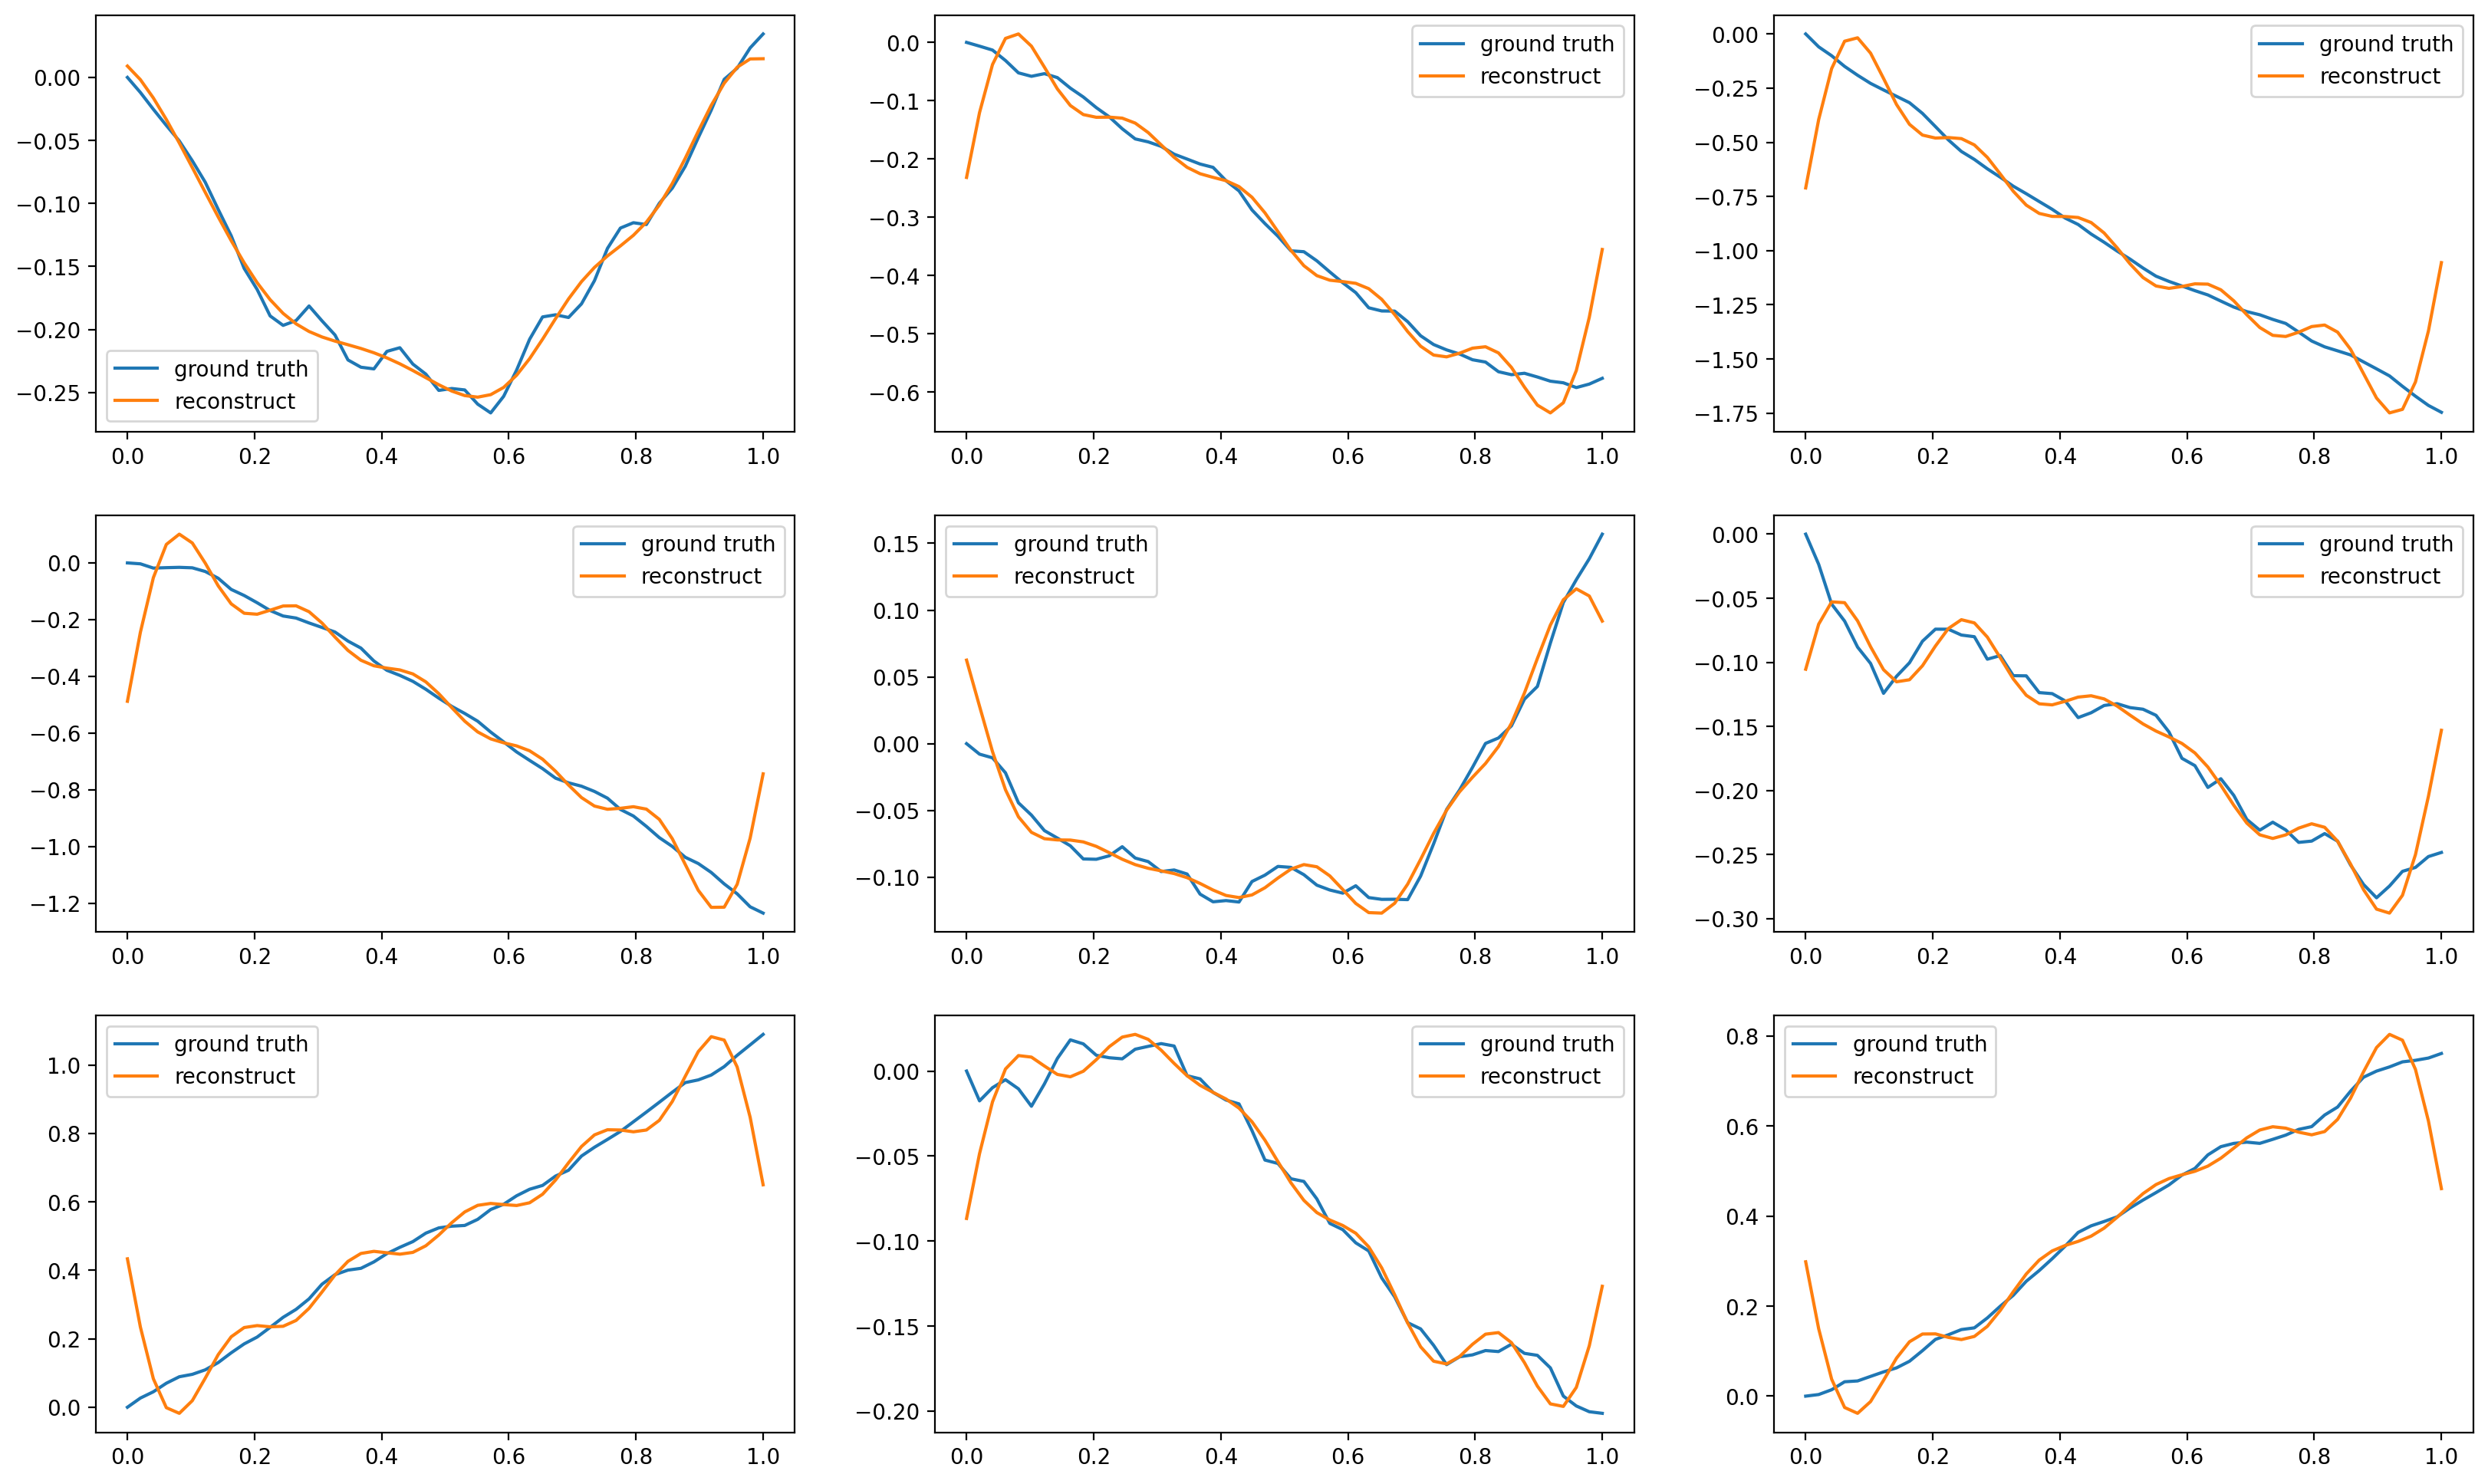

In [342]:
num = 9
plt.figure(figsize=(20, 12), dpi=200)
for idx in range(num):
    example_path = data.path[idx]
    recon_path = data.reconstruct_path(idx=idx).flatten()
    plt.subplot(int(num**0.5), int(num**0.5), idx+1)
    plt.plot(np.linspace(0, 1, n), example_path, label='ground truth')
    plt.plot(np.linspace(0, 1, n), recon_path, label='reconstruct')
    plt.legend()

#### Linear regression model

In [343]:
reg = LinearRegression().fit(data.inputs, data.labels)
# reg = Ridge(alpha=1).fit(data.inputs, data.labels)
# reg = Lasso(alpha=3).fit(data.inputs, data.labels)

In [344]:
train_score = reg.score(data.inputs, data.labels)
test_score = reg.score(test_data.inputs, test_data.labels)
print("training R score: ", train_score)
print("testing R score: ", test_score)

training R score:  0.9826880479796355
testing R score:  0.8271928921761199


#### Predict Performance

Text(0.5, 0.98, 'training paths')

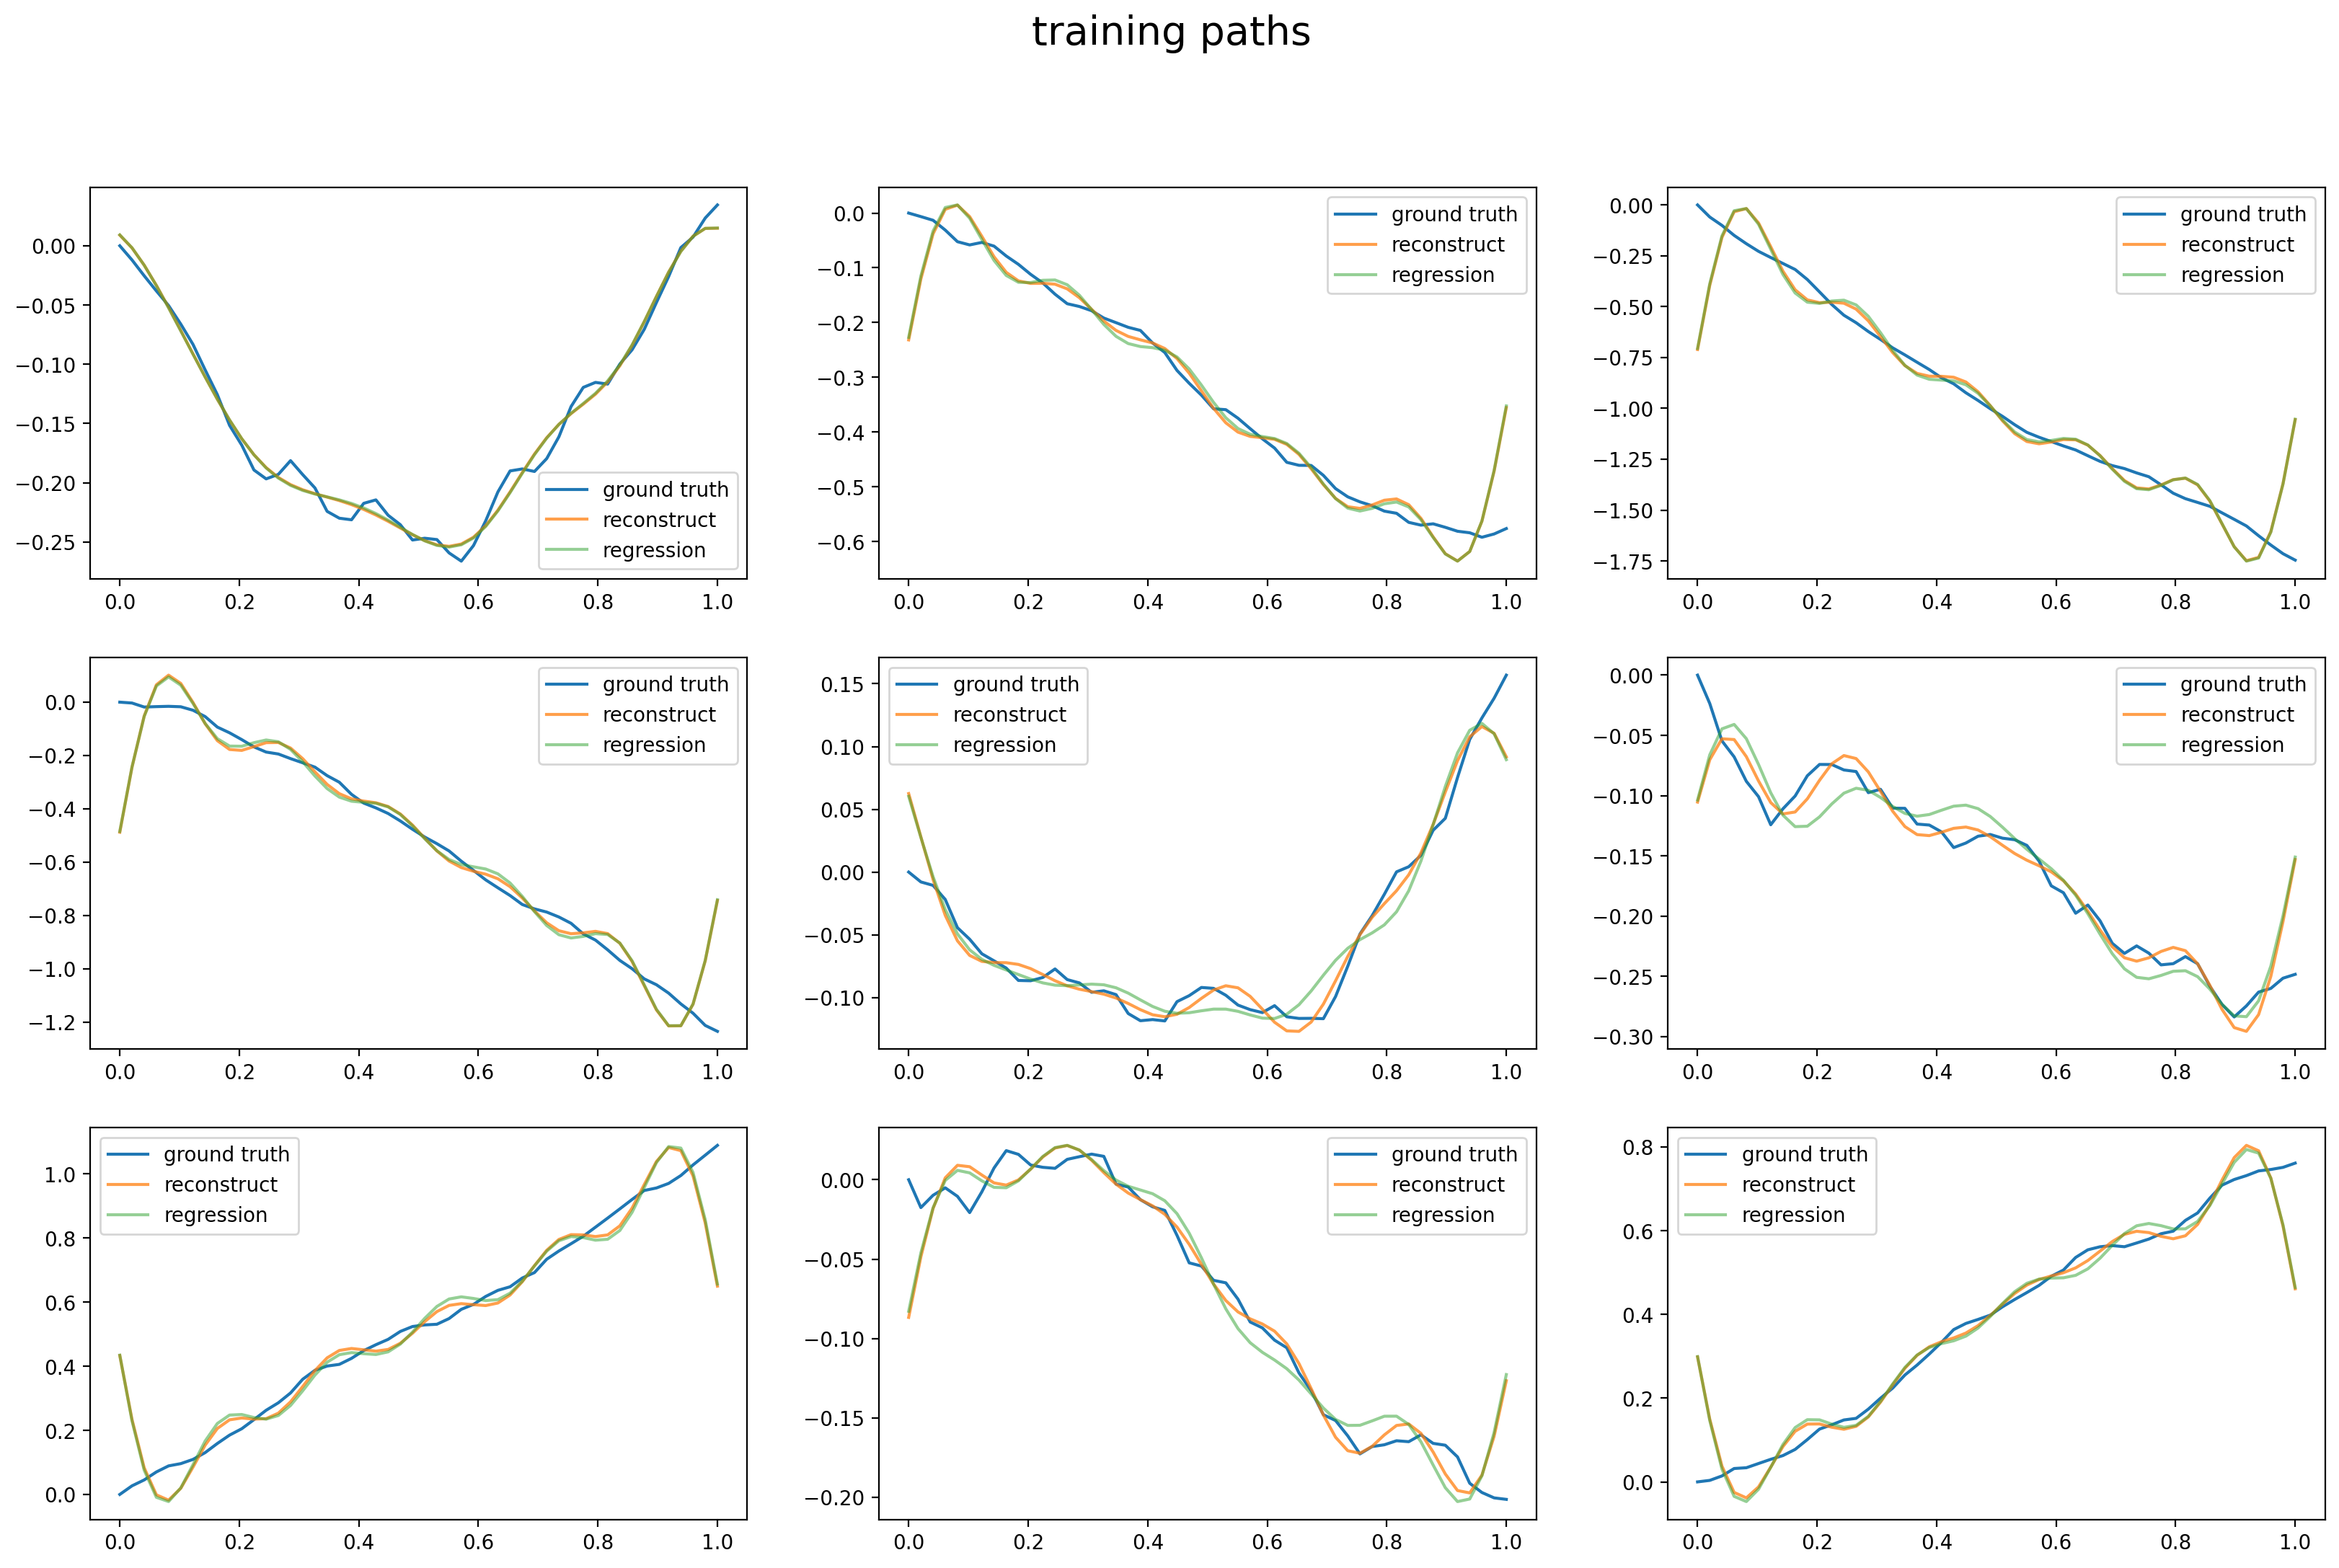

In [345]:
num = 9
reg_coef = reg.predict(data.inputs[:num])
reg_paths = ifft_aug(reg_coef, n=n, f_depth=f_depth)
plt.figure(figsize=(20, 12), dpi=200)
for idx in range(num):
    example_path = data.path[idx]
    recon_path = data.reconstruct_path(idx=idx).flatten()
    reg_path = reg_paths[idx]
    plt.subplot(int(num**0.5), int(num**0.5), idx+1)
    plt.plot(np.linspace(0, 1, n), example_path, label='ground truth')
    plt.plot(np.linspace(0, 1, n), recon_path, alpha=0.75, label='reconstruct')
    plt.plot(np.linspace(0, 1, n), reg_path, alpha=0.5, label='regression')
    plt.legend()
plt.suptitle('training paths', fontsize=20)

Text(0.5, 0.98, 'test paths')

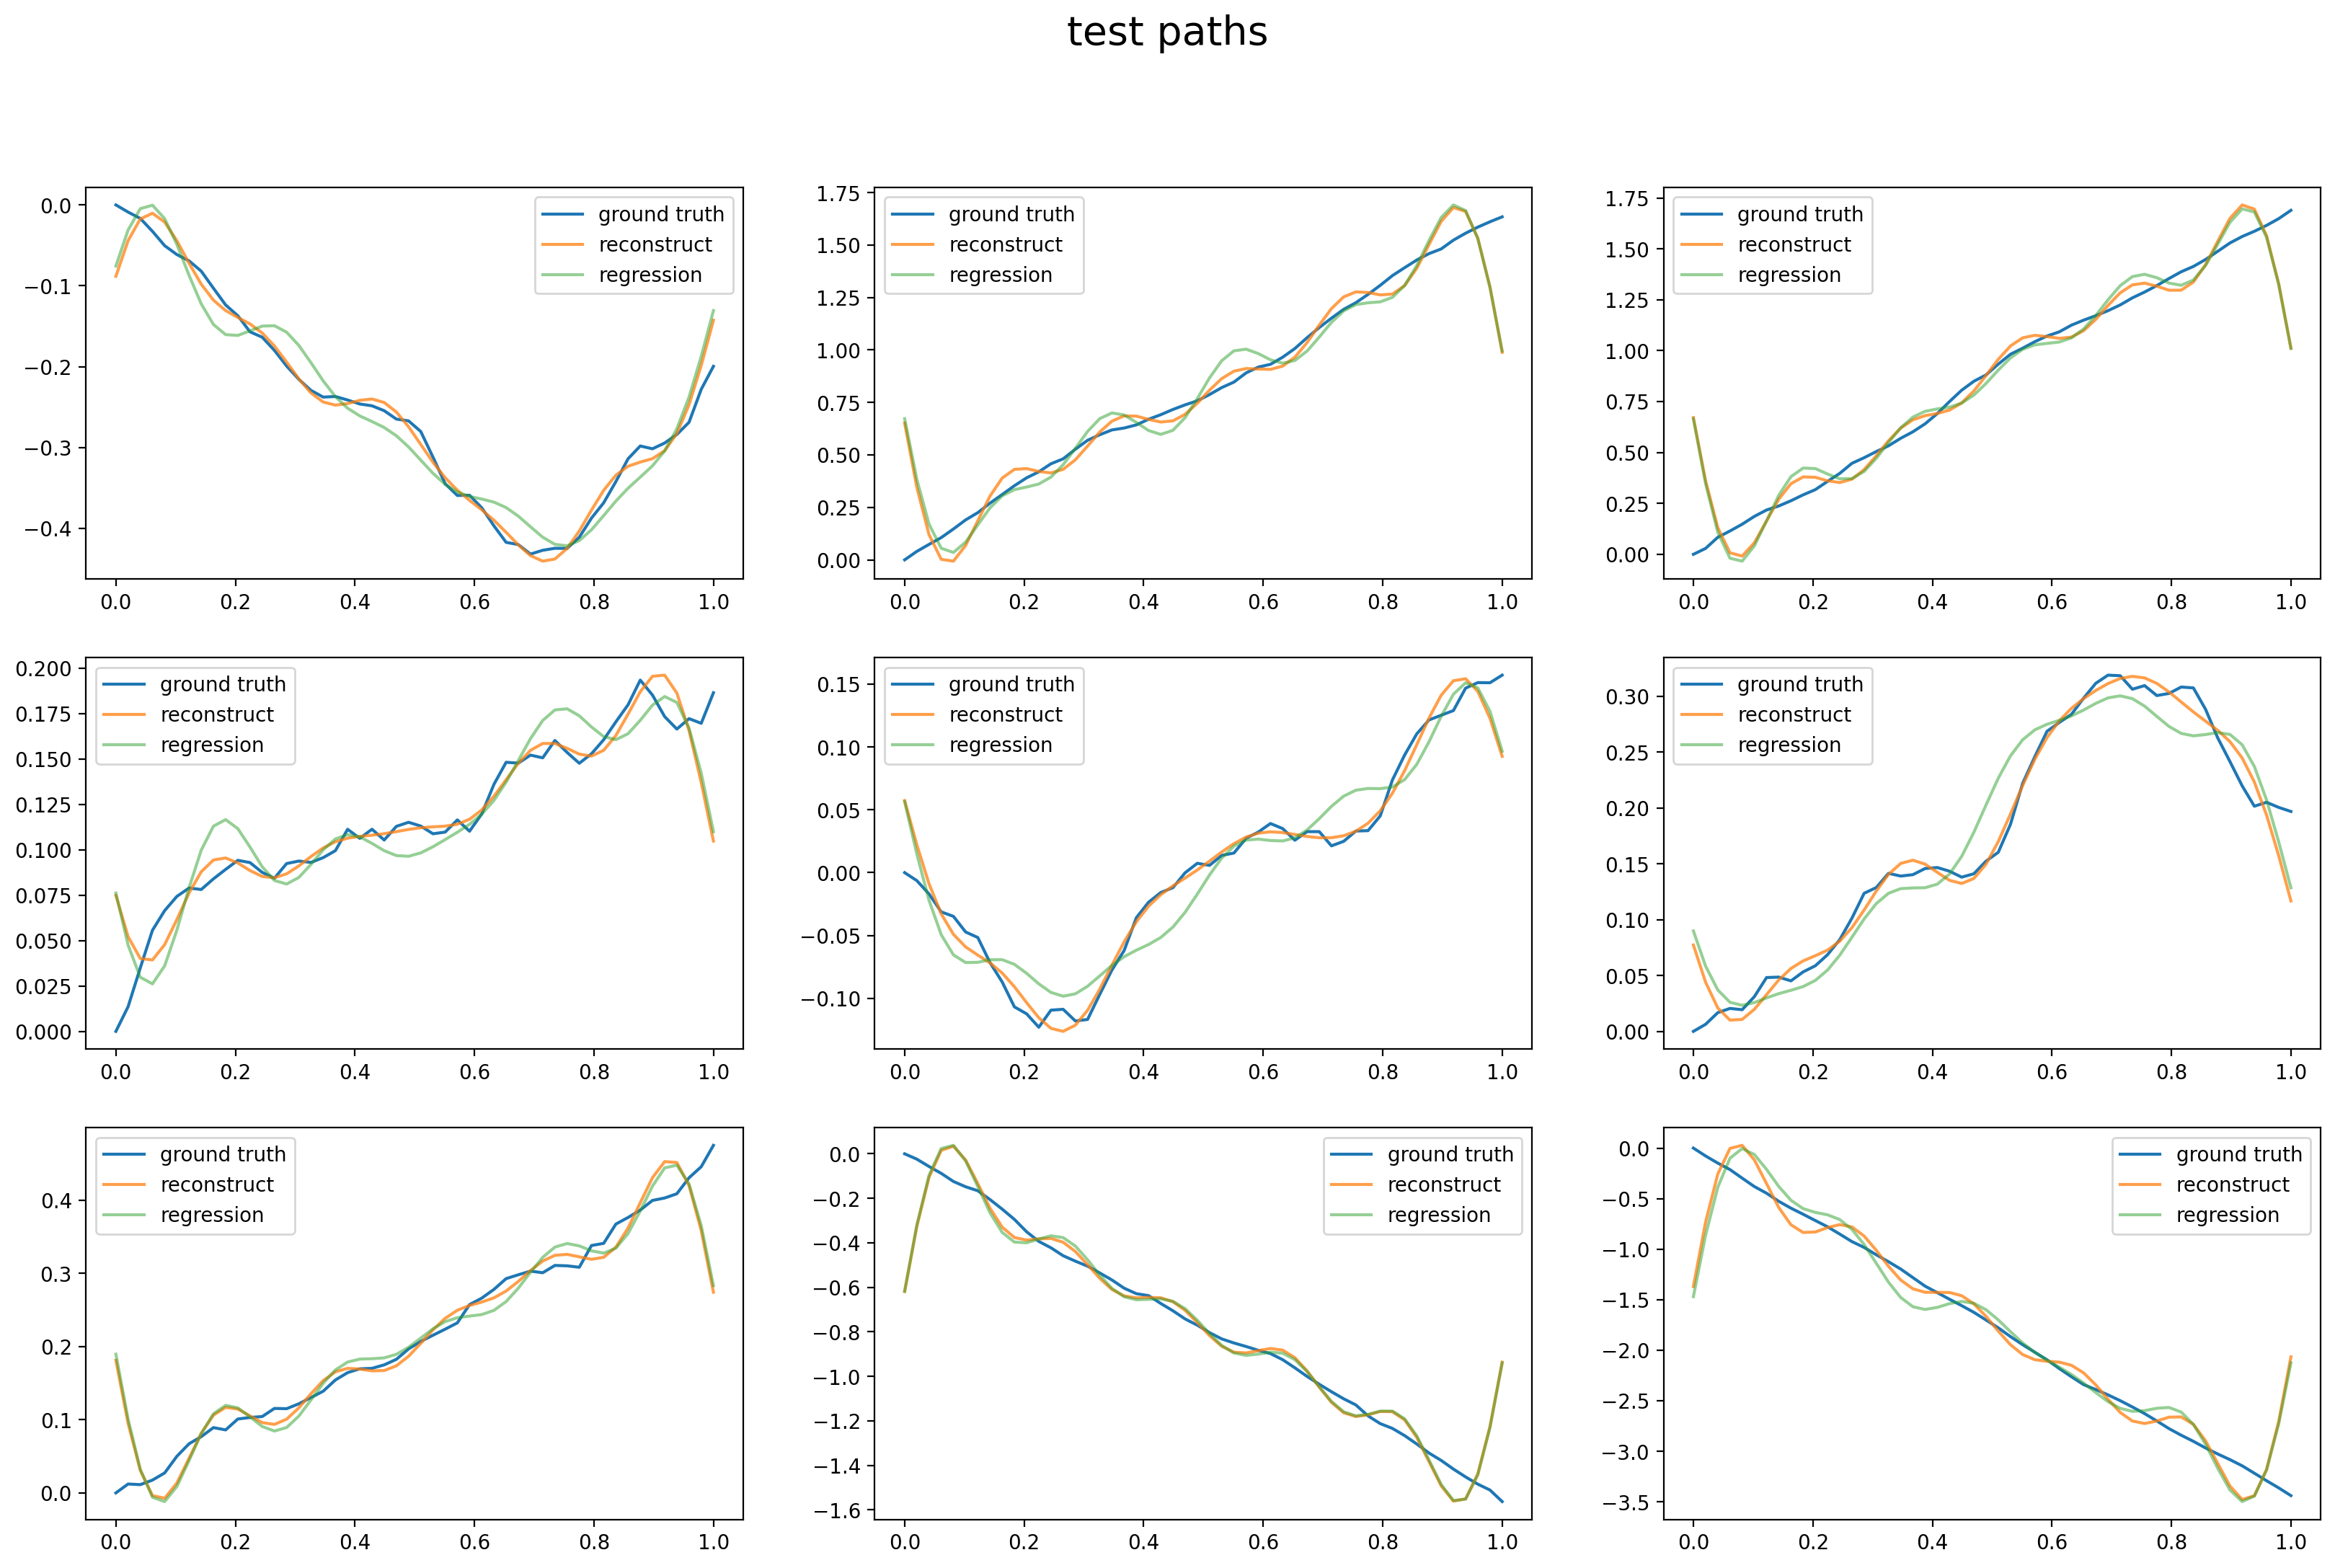

In [346]:
num = 9
test_reg_coef = reg.predict(test_data.inputs[:num])
test_reg_paths = ifft_aug(test_reg_coef, n=n, f_depth=f_depth)
plt.figure(figsize=(20, 12), dpi=200)
for idx in range(num):
    test_example_path = test_data.path[idx]
    test_recon_path = test_data.reconstruct_path(idx=idx).flatten()
    test_reg_path = test_reg_paths[idx]
    plt.subplot(int(num**0.5), int(num**0.5), idx+1)
    plt.plot(np.linspace(0, 1, n), test_example_path, label='ground truth')
    plt.plot(np.linspace(0, 1, n), test_recon_path, alpha=0.75, label='reconstruct')
    plt.plot(np.linspace(0, 1, n), test_reg_path, alpha=0.5, label='regression')
    plt.legend()
plt.suptitle('test paths', fontsize=20)